# ECommerce_SVD_KMeans_Unsupervised

## Data Loading and Exploratory Data Analysis

In [1]:
import gensim
import nltk
import numpy as np
import pandas as pd
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
## Read the data set from a CSV file
## There is no header row in the input file.
## The first column is the label or Product_Category, and the 2nd column is
## the product and description as a string.
df = pd.read_csv('./data/ecommerceDataset.csv',header=None)

df.columns=['product_category','raw_text']
df

,product_category,raw_text
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,Household,Incredible Gifts India Wooden Happy Birthday U...
...,...,...
50420,Electronics,Strontium MicroSD Class 10 8GB Memory Card (Bl...
50421,Electronics,CrossBeats Wave Waterproof Bluetooth Wireless ...
50422,Electronics,Karbonn Titanium Wind W4 (White) Karbonn Titan...
50423,Electronics,"Samsung Guru FM Plus (SM-B110E/D, Black) Colou..."


In [3]:
## Print a few samples of the first and last product descriptions

for i in range(4):
    print('')
    print(df.iloc[i,0])
    print('        '+df.iloc[i,1])
    
for i in range(4):
    print('')
    print(df.iloc[-i-1,0])
    print('        '+df.iloc[-i-1,1])


Household
        Paper Plane Design Framed Wall Hanging Motivational Office Decor Art Prints (8.7 X 8.7 inch) - Set of 4 Painting made up in synthetic frame with uv textured print which gives multi effects and attracts towards it. This is an special series of paintings which makes your wall very beautiful and gives a royal touch. This painting is ready to hang, you would be proud to possess this unique painting that is a niche apart. We use only the most modern and efficient printing technology on our prints, with only the and inks and precision epson, roland and hp printers. This innovative hd printing technique results in durable and spectacular looking prints of the highest that last a lifetime. We print solely with top-notch 100% inks, to achieve brilliant and true colours. Due to their high level of uv resistance, our prints retain their beautiful colours for many years. Add colour and style to your living space with this digitally printed painting. Some are for pleasure and som

In [4]:
## Count the occurences of each product category
df['product_category'].value_counts()

Household                 19313
Books                     11820
Electronics               10621
Clothing & Accessories     8671
Name: product_category, dtype: int64

### Data Cleaning 


The data has no missing values, but the product descriptions are free-form text. We plan to use scikit-learn TF-IDF to extract features from each product description. But the first steps are to convert all the text to lower case, remove all punctuation and non-alphabetic characters, and remove English stop words.

In [5]:
match_non_alpha = re.compile(r'[^-a-z]+')

def clean_words(text):
    """
    1) Change all text to lower case.
    2) Substitute space for all non-alphabetic characters (allow hyphen to remain)
    3) Split into word tokens and drop English stop words (using ENGLISH_STOP_WORDS from sklearn.feature_extraction.text
    4) Remove single letter tokens
    4) Return a string which concatenates all remaining words in each text.
    """
    text2 = match_non_alpha.sub(r' ',text.lower())
    tokens = text2.split(' ')
    cleaned = []
    for token in tokens:
        ## Also remove single letter tokens, 
        ## Also remove English stop words from scikit-learn feature_extraction
        if len(token) > 1 and token not in ENGLISH_STOP_WORDS:
            cleaned.append(token)
    clean_text = ' '.join(cleaned)
    return clean_text
        
## function to count words in text
def count_words(text):
    return len (text.split(' '))

In [6]:
df['cleaned_text'] = df['raw_text'].apply(clean_words)
df

,product_category,raw_text,cleaned_text
0,Household,Paper Plane Design Framed Wall Hanging Motivat...,paper plane design framed wall hanging motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...",saf floral framed painting wood inch inch spec...
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...,saf uv textured modern art print framed painti...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1...",saf flower print framed painting synthetic inc...
4,Household,Incredible Gifts India Wooden Happy Birthday U...,incredible gifts india wooden happy birthday u...
...,...,...,...
50420,Electronics,Strontium MicroSD Class 10 8GB Memory Card (Bl...,strontium microsd class gb memory card black m...
50421,Electronics,CrossBeats Wave Waterproof Bluetooth Wireless ...,crossbeats wave waterproof bluetooth wireless ...
50422,Electronics,Karbonn Titanium Wind W4 (White) Karbonn Titan...,karbonn titanium wind white karbonn titanium w...
50423,Electronics,"Samsung Guru FM Plus (SM-B110E/D, Black) Colou...",samsung guru fm plus sm-b black colour black c...


In [7]:
df['word_counts'] = df['cleaned_text'].apply(count_words)
df

,product_category,raw_text,cleaned_text,word_counts
0,Household,Paper Plane Design Framed Wall Hanging Motivat...,paper plane design framed wall hanging motivat...,121
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...",saf floral framed painting wood inch inch spec...,36
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...,saf uv textured modern art print framed painti...,114
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1...",saf flower print framed painting synthetic inc...,92
4,Household,Incredible Gifts India Wooden Happy Birthday U...,incredible gifts india wooden happy birthday u...,91
...,...,...,...,...
50420,Electronics,Strontium MicroSD Class 10 8GB Memory Card (Bl...,strontium microsd class gb memory card black m...,57
50421,Electronics,CrossBeats Wave Waterproof Bluetooth Wireless ...,crossbeats wave waterproof bluetooth wireless ...,11
50422,Electronics,Karbonn Titanium Wind W4 (White) Karbonn Titan...,karbonn titanium wind white karbonn titanium w...,153
50423,Electronics,"Samsung Guru FM Plus (SM-B110E/D, Black) Colou...",samsung guru fm plus sm-b black colour black c...,201


In [8]:
df['word_counts'].describe()

count    50425.000000
mean        69.289479
std         84.336362
min          1.000000
25%         24.000000
50%         49.000000
75%         91.000000
max       4016.000000
Name: word_counts, dtype: float64

In [9]:
## It turns out that after removing stop words and puctuation, etc, 
## A few of the cleaned_text values are empty. We will drop these rows
## from the data frame.

df[df['cleaned_text']=='']

,product_category,raw_text,cleaned_text,word_counts
21375,Books,281 and Beyond,,1
23178,Books,281 and Beyond,,1
23976,Books,281 and Beyond,,1
27423,Books,Becoming,,1
30549,Books,Becoming,,1
39330,Clothing & Accessories,,,1


In [10]:
df=df[df['cleaned_text']!='']
df

,product_category,raw_text,cleaned_text,word_counts
0,Household,Paper Plane Design Framed Wall Hanging Motivat...,paper plane design framed wall hanging motivat...,121
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...",saf floral framed painting wood inch inch spec...,36
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...,saf uv textured modern art print framed painti...,114
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1...",saf flower print framed painting synthetic inc...,92
4,Household,Incredible Gifts India Wooden Happy Birthday U...,incredible gifts india wooden happy birthday u...,91
...,...,...,...,...
50420,Electronics,Strontium MicroSD Class 10 8GB Memory Card (Bl...,strontium microsd class gb memory card black m...,57
50421,Electronics,CrossBeats Wave Waterproof Bluetooth Wireless ...,crossbeats wave waterproof bluetooth wireless ...,11
50422,Electronics,Karbonn Titanium Wind W4 (White) Karbonn Titan...,karbonn titanium wind white karbonn titanium w...,153
50423,Electronics,"Samsung Guru FM Plus (SM-B110E/D, Black) Colou...",samsung guru fm plus sm-b black colour black c...,201


In [11]:
## Descriptive statistics for word counts in the cleaned product descriptions
df['word_counts'].describe()

count    50419.000000
mean        69.297606
std         84.338090
min          1.000000
25%         24.000000
50%         49.000000
75%         91.000000
max       4016.000000
Name: word_counts, dtype: float64

In [12]:
## Create a list of all (cleaned) words used in the product descriptions
## and identify the 50 most frequently occuring words
corpus = list(df['cleaned_text'])

all_words = []
for text in corpus:
    all_words.extend(text.split(' '))
    
print(f'Total Words in the corpus = {len(all_words)}')

all_word_series = pd.Series(all_words)
display(all_word_series.describe())
    
top_50 = pd.DataFrame(
    Counter(all_words).most_common(50),
    columns=['word', 'frequency']
)

top_50

Total Words in the corpus = 3493916


count     3493916
unique      76577
top          size
freq        13063
dtype: object

,word,frequency
0,size,13063
1,book,12658
2,use,12166
3,set,12136
4,easy,11476
5,quality,11215
6,product,10963
7,black,10813
8,home,10496
9,design,10357


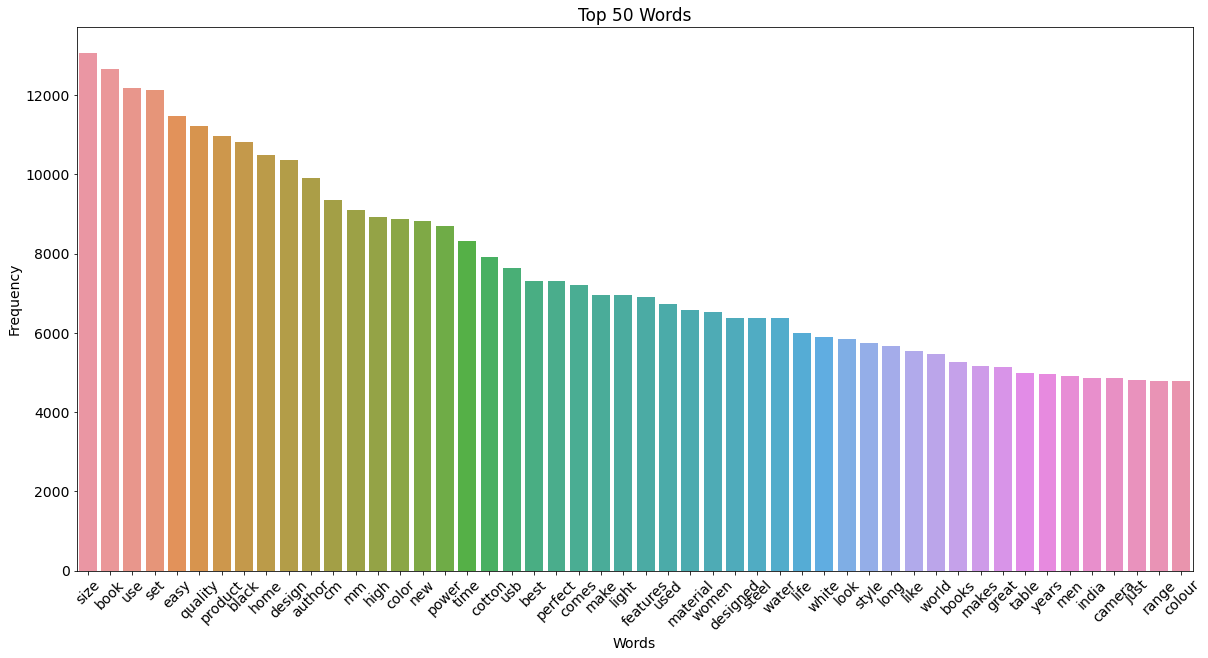

In [13]:
# Plot a bar chart for the top 50 most frequently occuring words
fig = plt.figure(figsize=(20,10))

g = sns.barplot(
    x='word',
    y='frequency',
    data=top_50,
)

g.set_xticklabels(
    g.get_xticklabels(),
    rotation=45,
    fontsize=14
)

plt.yticks(fontsize=14)
plt.xlabel('Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Top 50 Words', fontsize=17)

plt.show()

# Feature Creation using scikit-learn TF-IDF


We will be using <b>TF-IDF</b> or Term Frequency - Inverse Document Frequency as a way to encode features from the collections of words in each document (product description). The <b>corpus</b> is the set of all words appearing in all documents being considered. A <b>term</b> is a word that appears in the corpus, or a short sequence of specific words. When sequences of words are considered they are called  <b>n-grams</b>. The NGRAM_RANGE defines the minimum and maximum length of the sequences considered.

The ti=f-idf value is proportial to the number of times a term is used in each specific document, and is weighted lower for terms that appear frequently in many documents in the corpus. Terms that appear frequently in given documents may be strong indications of the topics in the document, but terms that appear frequently across many documement provide little specific information.

The scikit-learn TfidfVectorizer determines the frequency of all the terms in the corpus across all documents and across
each specific document being considered. The N most frequent terms in the corpus are used to define a fixed length vector.
This vector is computed for each specific document by computing the tf-idf value of that term in that document for each of the  N most frequent terms in the corpus. This results a fixed-length vector encoding for the collection of words in each document.


In [14]:
%%time

MAX_FEATURES = 10000 ## Build a vocabulary using the only the top max_features ordered by term frequency across the corpus.
MIN_DF = 1 ## Minimum Term Frequency Per Document. Ignore terms that appear less than this number of times in a given document
MAX_DF = 0.85 ## Maximum Document Frequency. Ignore terms that appear in more than this proportion of all documents
NGRAM_RANGE = (1,2)

## Create the tf-idf vectors for all the train and test documents as one corpus
tfidf_vectorizer = TfidfVectorizer(
    min_df=MIN_DF,
    max_df=MAX_DF,
    max_features=MAX_FEATURES,
    ngram_range=NGRAM_RANGE,
)

all_docs = list(df['cleaned_text'])
tfidf = tfidf_vectorizer.fit_transform(all_docs)



CPU times: total: 7.2 s
Wall time: 7.22 s


In [15]:
display(f'{tfidf.shape=}')

display(f'{type(tfidf)=}')


'tfidf.shape=(50419, 10000)'

"type(tfidf)=<class 'scipy.sparse.csr.csr_matrix'>"

In [16]:
%%time

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer


lsa = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=True))

X_lsa = lsa.fit_transform(tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"Explained variance of the SVD step: {explained_variance:.1%}")

Explained variance of the SVD step: 17.3%
CPU times: total: 15.8 s
Wall time: 2.94 s


<function matplotlib.pyplot.show(close=None, block=None)>

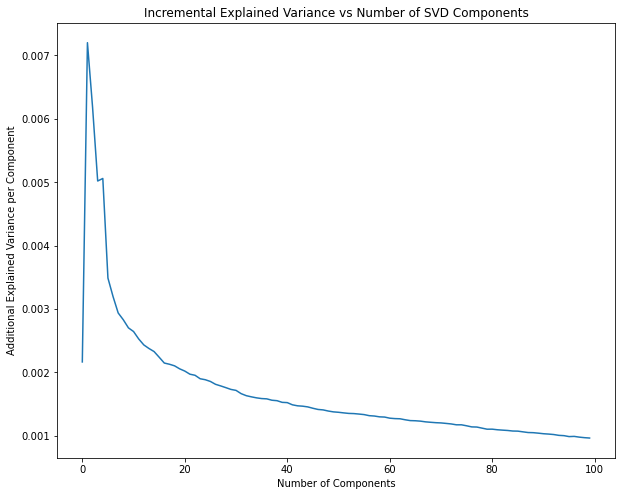

In [17]:
explained_var = lsa.named_steps['truncatedsvd'].explained_variance_
plt.figure(figsize=(10,8))
plt.title("Incremental Explained Variance vs Number of SVD Components")
plt.xlabel("Number of Components")
plt.ylabel("Additional Explained Variance per Component")
plt.plot(explained_var)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

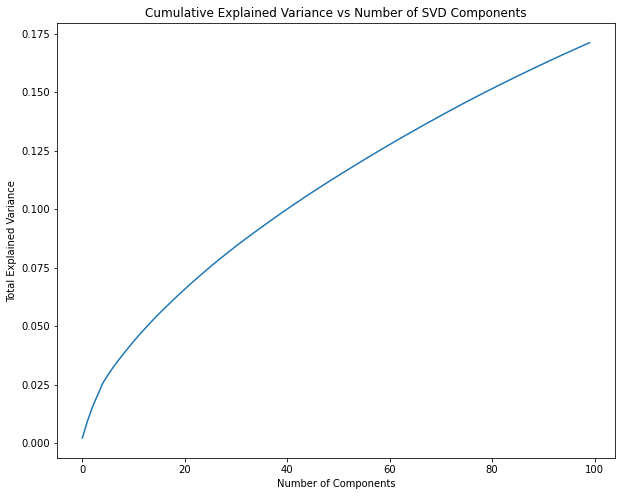

In [18]:
explained_var = lsa.named_steps['truncatedsvd'].explained_variance_
plt.figure(figsize=(10,8))
plt.title("Cumulative Explained Variance vs Number of SVD Components")
plt.xlabel("Number of Components")
plt.ylabel("Total Explained Variance")
cumvar = pd.Series(explained_var).cumsum()
plt.plot(cumvar)
plt.show

In [19]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from itertools import permutations

def perform_SVD_on_tfidf_matrix( n_components=2):
    pipe = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=True))
    svd = pipe.fit_transform(tfidf)
    return svd

def perform_KMeans_on_SVD_features(svd):
    km = KMeans(init="random",
            n_clusters=4,
            n_init=10, 
            max_iter=300,
            random_state=42)
    km.fit(svd)
    return km

labels_int = list(range(4))
print(f'{labels_int=}')

categories = df['product_category'].unique()
print(f'{categories=}')

def match_KMeans_clusters_to_products(km, n_components):
    """
    Try all permutations of 4 KMeans clusters against 4 product_categories,
    selecting the assignment with highest accuracy against true labels.
    """
    best_score = 0
    best_labels = None
    best_permutation = None
    for p in permutations(labels_int):
        ## This loop generates all permutations of the cluster labels produced by KMeans.
        ## We retain the permuted labels that produce the highest accuracy. In this way,
        ## we discover which cluster corresponds to which product category.
        permuted = labels_permuted(km.labels_, p, categories)
        score = accuracy_score(df['product_category'], permuted)
        if score > best_score:
            best_labels = permuted
            best_score = score
            best_permutation = p
    print(f'Accuracy score for {n_components} SVD components = {best_score}')
    return best_score, best_labels
    
def labels_permuted(labels, permutation, categories):
    """
    This function applies a given permutation to the cluster labels produced by KMeans,
    and returns a list of product_category names, corresponding to the permutation.
    """
    permuted_labels = []
    for x in labels:
        ix = permutation[x]
        permuted_labels.append(categories[ix])
    return permuted_labels

labels_int=[0, 1, 2, 3]
categories=array(['Household', 'Books', 'Clothing & Accessories', 'Electronics'],
      dtype=object)


In [20]:
## Try different numbers of components for SVD dimension reduction of the TFIDF matrix.
try_components = [1,2,3,4,5,6,7,8,9,10,12,15,20,25,30,40,50,60,80,100]

accuracy_vs_components = []
best_score = 0
best_labels = None
best_n = None

for n_components in try_components:
    svd = perform_SVD_on_tfidf_matrix(n_components)
    km = perform_KMeans_on_SVD_features(svd)
    score, labels = match_KMeans_clusters_to_products(km, n_components)
    accuracy_vs_components.append(score)
    if score > best_score:
        best_n = n_components
        best_score = score
        best_labels = labels

print(f'best accuracy = {best_score:.4f} for n_components = {best_n}')   

Accuracy score for 1 SVD components = 0.8246692715047899
Accuracy score for 2 SVD components = 0.8264741466510641
Accuracy score for 3 SVD components = 0.8276641742200361
Accuracy score for 4 SVD components = 0.8309367500347091
Accuracy score for 5 SVD components = 0.8641385192090283
Accuracy score for 6 SVD components = 0.8625716495765485
Accuracy score for 7 SVD components = 0.8237172494496122
Accuracy score for 8 SVD components = 0.858466054463595
Accuracy score for 9 SVD components = 0.8286955314464786
Accuracy score for 10 SVD components = 0.8612427854578631
Accuracy score for 12 SVD components = 0.8269699914714691
Accuracy score for 15 SVD components = 0.8263749776869831
Accuracy score for 20 SVD components = 0.8578313730934767
Accuracy score for 25 SVD components = 0.8640393502449474
Accuracy score for 30 SVD components = 0.8326622900097186
Accuracy score for 40 SVD components = 0.8293897141950455
Accuracy score for 50 SVD components = 0.7881949265157976
Accuracy score for 60 SV

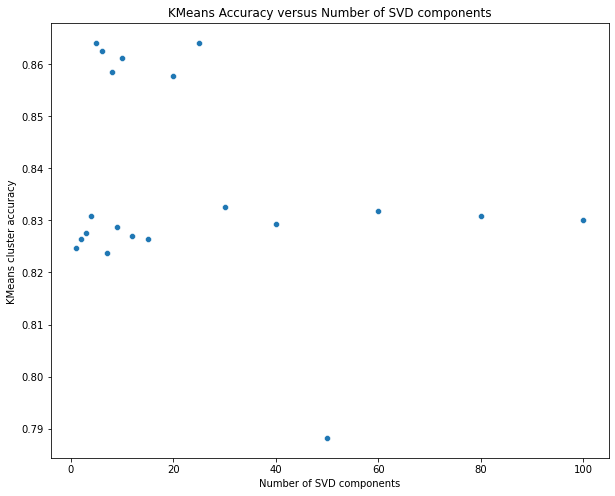

In [21]:
plt.figure(figsize=(10,8))
plt.title("KMeans Accuracy versus Number of SVD components")
plt.xlabel("Number of SVD components")
plt.ylabel("KMeans cluster accuracy ")
sns.scatterplot(x=try_components, y=accuracy_vs_components)
plt.show()

In [22]:
best_score = accuracy_score(df['product_category'], best_labels)

print(f'Best accuracy of KMeans clustering versus true labels was {best_score:.4f}')

Best accuracy of KMeans clustering versus true labels was 0.8641


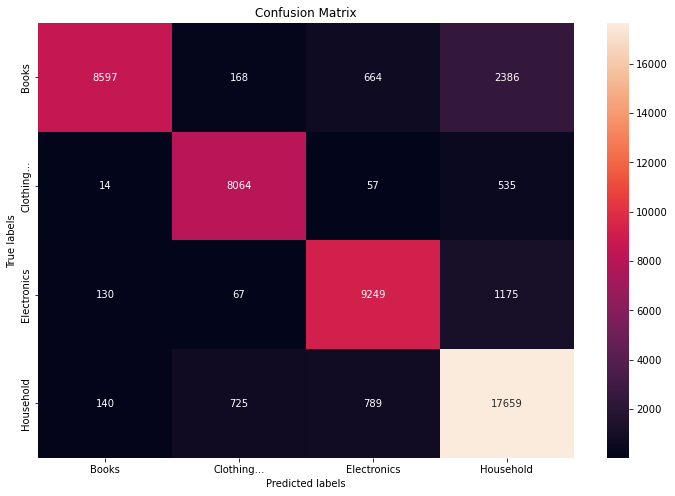

In [23]:
# display confusion matrix here 

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 
label_names = ['Books','Clothing...','Electronics','Household']
cm = confusion_matrix(df['product_category'], best_labels)
fig = plt.figure(figsize=(12,8))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(label_names); 
ax.yaxis.set_ticklabels(label_names);

In [24]:
df_components = pd.DataFrame({'try_components': try_components, 'accuracy_vs_components':accuracy_vs_components})
df_components.to_csv('data/accuracy_vs_components.csv',index=False)

In [25]:
df_components['accuracy_vs_components'].describe()

count    20.000000
mean      0.836337
std       0.019212
min       0.788195
25%       0.826846
50%       0.830481
75%       0.857990
max       0.864139
Name: accuracy_vs_components, dtype: float64